In [98]:
import time, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle, islice
from sklearn import datasets, cluster, mixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

def multiple_bar_chart(ax: plt.Axes, xvalues: list, yvalues: dict, title: str, xlabel: str, ylabel: str, percentage=False):

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    x = np.arange(len(xvalues))  # the label locations
    ax.set_xticks(x)
    ax.set_xticklabels(xvalues, fontsize='small')
    if percentage:
        ax.set_ylim(0.0, 1.0)
    width = 0.8  # the width of the bars
    step = width / len(yvalues)
    k = 0
    for name, y in yvalues.items():
        ax.bar(x + k * step, y, step, label=name)
        k += 1
    ax.legend(loc='lower center', ncol=len(yvalues), bbox_to_anchor=(0.5, -0.2), fancybox = True, shadow = True) 

# PD Speech Features dataset

In [99]:
data = pd.read_csv('pd_speech_features.csv', sep=',')
data = data.sort_values('id', ascending=True)

#Fazer a média das 3 medições com o mesmo id
data = data.groupby('id').mean().reset_index()

In [100]:
# Normalization
transf = MinMaxScaler().fit(data)
data = pd.DataFrame(transf.transform(data), columns= data.columns)

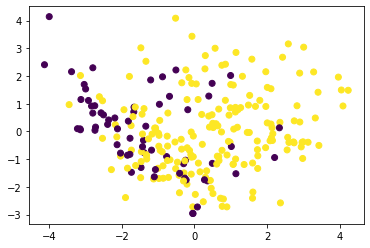

In [101]:
X = data.drop(columns=['class', 'id'])
y = data['class'].values

from sklearn.decomposition import PCA
X = PCA(n_components=2, random_state=1).fit_transform(X)

from sklearn.feature_selection import SelectKBest, chi2, f_classif
#X = SelectKBest(f_classif, k=2).fit_transform(X, y)

plt.subplot(111)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

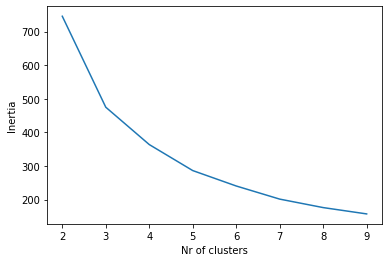

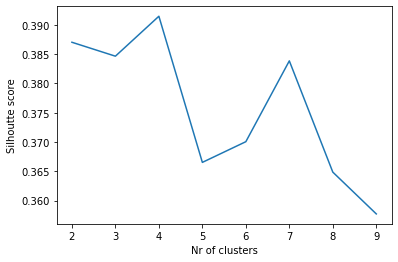

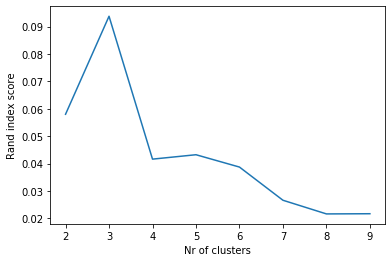

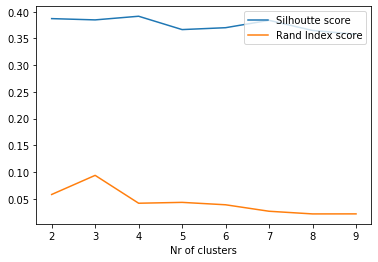

In [102]:
n_of_cluster = []
inertia_values = []
silhouette_values = []
rand_index_values = []

for i in range(2, 10):
    kmeans_model = cluster.KMeans(n_clusters=i, random_state=1).fit(X)
    y_pred = kmeans_model.labels_
    n_of_cluster.append(i) 
    inertia_values.append(kmeans_model.inertia_)
    silhouette_values.append(silhouette_score(X, y_pred))
    rand_index_values.append(adjusted_rand_score(y, y_pred))

# Inertia, diferença entre valores dentro do mesmo cluster, quão coerentes os clusters são internamente, o objetivo é minimizar este valor
plt.plot(n_of_cluster, inertia_values)
plt.xlabel("Nr of clusters")
plt.ylabel("Inertia")
plt.show()

# Silhouette, quão bem classificado está um sample no seu cluster, quanto mais alto for o valor melhor definido está o cluster
plt.plot(n_of_cluster, silhouette_values)
plt.xlabel("Nr of clusters")
plt.ylabel("Silhoutte score")
plt.show()

# Ajusted Rand Indexes, é a similariedade entre dois clusters, usamos para comparar o predicted com o verdadeiro
# requer saber as classes verdadeiras, 
# o valor 1.0 que é o mais alto é o perfeito significa classificação de labels perfeita
# distribuição uniforme (random) de labels tem um valor de 0.0
plt.plot(n_of_cluster, rand_index_values)
plt.xlabel("Nr of clusters")
plt.ylabel("Rand index score")
plt.show()

plt.plot(n_of_cluster, silhouette_values, label="Silhoutte score")
plt.plot(n_of_cluster, rand_index_values, label="Rand Index score")
plt.legend(loc='upper right')
plt.xlabel("Nr of clusters")
plt.show()

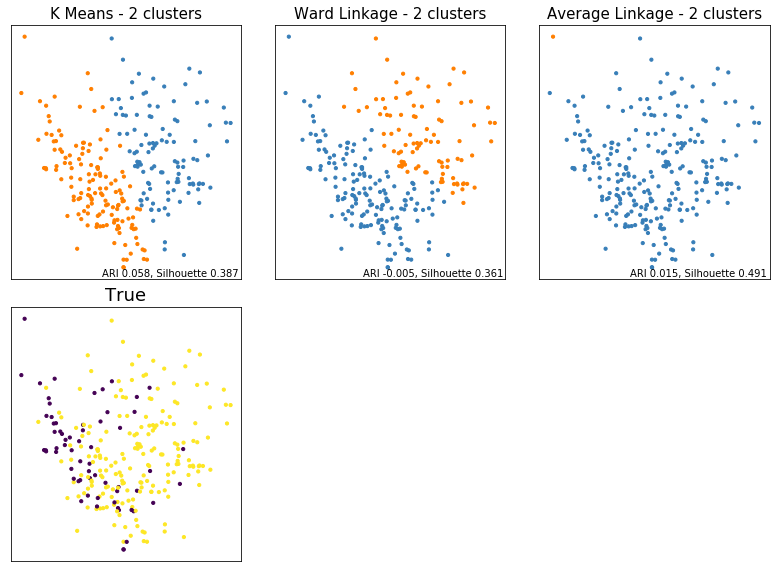

In [103]:
algorithms = {}
n_clusters = 2
    
# 1b Parameterize clustering algorithms
algorithms['K Means'] = cluster.KMeans(n_clusters=n_clusters, random_state=1)
algorithms['Ward Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
algorithms['Average Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='average')

# 3 Run clustering algorithm and store predictions
predictions = {}
efficiency = {}
for idx, name in enumerate(algorithms):
    clustering = algorithms[name]
    t0 = time.time()
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        clustering.fit(X)
    efficiency[name]= time.time()-t0
    if hasattr(clustering, 'labels_'): predictions[name] = clustering.labels_.astype(np.int)
    else: predictions[name] = clustering.predict(X)


plt.figure(figsize=(11, 8))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
color_array = ['#377eb8','#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00']
plot_num = 1

for idx, name in enumerate(predictions):
    y_predi = predictions[name]
    plt.subplot(2, 3, plot_num)
    plt.tight_layout()
    plt.title(name+" - "+str(n_clusters)+" clusters", size=15)
    plt.xticks([])
    plt.yticks([])
    colors = np.array(list(islice(cycle(color_array),int(max(y_predi) + 1))))
    colors = np.append(colors, ["#000000"]) #black color for outliers (if any)
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_predi])
    silh = str('%.3f'%(silhouette_score(X, y_predi)))
    ari = str('%.3f'%(adjusted_rand_score(y, y_predi)))
    plt.text(.99, .01, 'ARI '+ari+', Silhouette '+silh, transform=plt.gca().transAxes,size=10,horizontalalignment='right')
    plot_num += 1
    
plt.subplot(2, 3, plot_num)
plt.title("True", size=18)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], s=10, c=y)

plt.show()

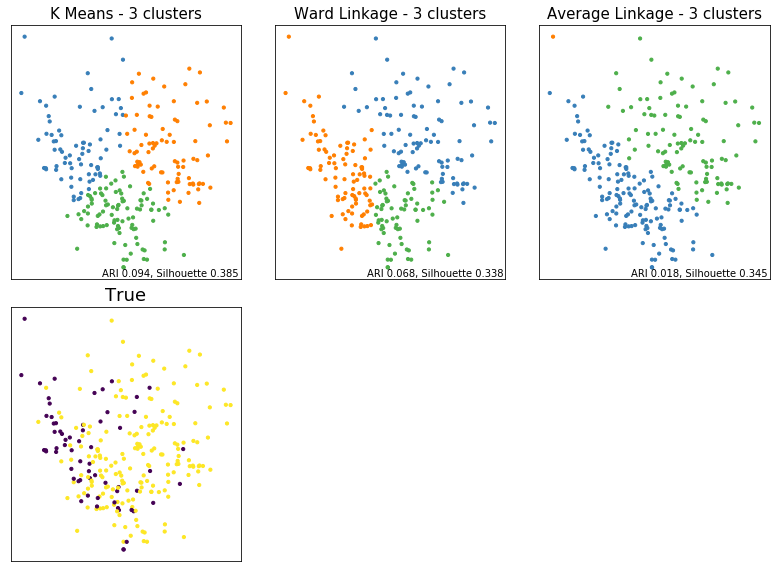

In [104]:
algorithms = {}
n_clusters = 3
    
# 1b Parameterize clustering algorithms
algorithms['K Means'] = cluster.KMeans(n_clusters=n_clusters, random_state=1)
algorithms['Ward Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
algorithms['Average Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='average')

# 3 Run clustering algorithm and store predictions
predictions = {}
efficiency = {}
for idx, name in enumerate(algorithms):
    clustering = algorithms[name]
    t0 = time.time()
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        clustering.fit(X)
    efficiency[name]= time.time()-t0
    if hasattr(clustering, 'labels_'): predictions[name] = clustering.labels_.astype(np.int)
    else: predictions[name] = clustering.predict(X)


plt.figure(figsize=(11, 8))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
color_array = ['#377eb8','#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00']
plot_num = 1

for idx, name in enumerate(predictions):
    y_predi = predictions[name]
    plt.subplot(2, 3, plot_num)
    plt.tight_layout()
    plt.title(name+" - "+str(n_clusters)+" clusters", size=15)
    plt.xticks([])
    plt.yticks([])
    colors = np.array(list(islice(cycle(color_array),int(max(y_predi) + 1))))
    colors = np.append(colors, ["#000000"]) #black color for outliers (if any)
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_predi])
    silh = str('%.3f'%(silhouette_score(X, y_predi)))
    ari = str('%.3f'%(adjusted_rand_score(y, y_predi)))
    plt.text(.99, .01, 'ARI '+ari+', Silhouette '+silh, transform=plt.gca().transAxes,size=10,horizontalalignment='right')
    plot_num += 1

plt.subplot(2, 3, plot_num)
plt.title("True", size=18)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], s=10, c=y)

plt.show()

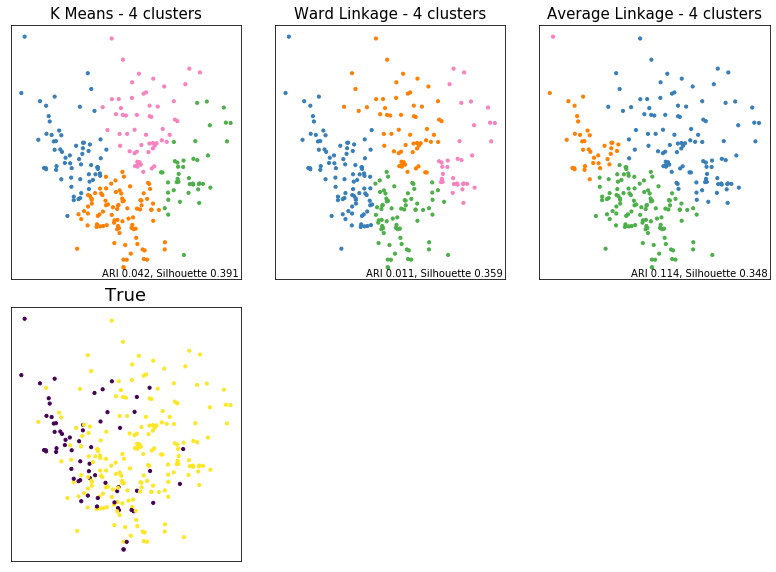

In [111]:
algorithms = {}
n_clusters = 4
    
# 1b Parameterize clustering algorithms
algorithms['K Means'] = cluster.KMeans(n_clusters=n_clusters, random_state=1)
algorithms['Ward Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
algorithms['Average Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='average')

# 3 Run clustering algorithm and store predictions
predictions = {}
efficiency = {}
for idx, name in enumerate(algorithms):
    clustering = algorithms[name]
    t0 = time.time()
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        clustering.fit(X)
    efficiency[name]= time.time()-t0
    if hasattr(clustering, 'labels_'): predictions[name] = clustering.labels_.astype(np.int)
    else: predictions[name] = clustering.predict(X)


plt.figure(figsize=(11, 8))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
color_array = ['#377eb8','#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00']
plot_num = 1

for idx, name in enumerate(predictions):
    y_predi = predictions[name]
    plt.subplot(2, 3, plot_num)
    plt.tight_layout()
    plt.title(name+" - "+str(n_clusters)+" clusters", size=15)
    plt.xticks([])
    plt.yticks([])
    colors = np.array(list(islice(cycle(color_array),int(max(y_predi) + 1))))
    colors = np.append(colors, ["#000000"]) #black color for outliers (if any)
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_predi])
    silh = str('%.3f'%(silhouette_score(X, y_predi)))
    ari = str('%.3f'%(adjusted_rand_score(y, y_predi)))
    plt.text(.99, .01, 'ARI '+ari+', Silhouette '+silh, transform=plt.gca().transAxes,size=10,horizontalalignment='right')
    plot_num += 1

plt.subplot(2, 3, plot_num)
plt.title("True", size=18)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], s=10, c=y)

plt.show()

# Best results for PD dataset 

|            | K Means - 3 clusters | Ward - 3 clusters | Average Linkage - 4 clusters |
|------------|----------------------|-------------------|------------------------------|
| Silhouette | 0,385                | 0,338             | 0,348                        |
| ARI        | 0,094                | 0,068             | 0,114                        |

The best is Average Linkage with 4 clusters

# Covtype dataset

In [116]:
data = pd.read_csv('covtype.csv', sep=',')
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type'].values
print(X.shape)

# não há missing values
from sklearn.impute import SimpleImputer

try:
    imp_nr = SimpleImputer(strategy='mean', missing_values=np.nan, copy=True)
    imp_sb = SimpleImputer(strategy='most_frequent', missing_values='', copy=True)
    df_nr = pd.DataFrame(imp_nr.fit_transform(cols_nr), columns=cols_nr.columns)
    df_sb = pd.DataFrame(imp_sb.fit_transform(cols_sb), columns=cols_sb.columns)
except:
    print("No missing values") 

#Não se faz dummify, pois não existem features do tipo category 
cols_sb = data.select_dtypes(include='category')
if cols_sb.empty:
    print('No category type columns!') #shows no categoriy types in the dataset
else:
    print('Exists category type columns!')

# Hold-Out 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.995, random_state=13)
print(X_train.shape)

# normalize
from sklearn.preprocessing import Normalizer

transf = StandardScaler().fit(X_train)
data = pd.DataFrame(transf.transform(X_train))
data.describe(include='all')

(581012, 54)
No missing values
No category type columns!
(2905, 54)


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,...,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03,2.905000e+03
mean,4.819151e-16,5.488056e-17,3.348631e-16,6.267696e-18,9.382436e-17,-1.807695e-17,-1.192009e-16,-2.706861e-16,-3.116077e-16,7.278553e-17,...,1.001245e-15,-4.196299e-16,2.031250e-15,2.255559e-16,-2.641700e-16,3.941268e-16,2.800853e-16,-2.027256e-16,-1.534687e-15,-1.986936e-16
std,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,...,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00,1.000172e+00
min,-3.662968e+00,-1.388147e+00,-1.829940e+00,-1.273783e+00,-2.960594e+00,-1.469913e+00,-5.217891e+00,-6.173409e+00,-3.707735e+00,-1.480748e+00,...,-2.120472e-01,-3.187956e-01,-2.827112e-01,-5.574706e-02,-6.440453e-02,-2.624771e-02,-2.624771e-02,-1.746633e-01,-1.616761e-01,-1.196480e-01
25%,-5.044975e-01,-8.841279e-01,-7.924738e-01,-7.699734e-01,-6.982204e-01,-8.101111e-01,-4.997310e-01,-5.416935e-01,-5.919913e-01,-7.248046e-01,...,-2.120472e-01,-3.187956e-01,-2.827112e-01,-5.574706e-02,-6.440453e-02,-2.624771e-02,-2.624771e-02,-1.746633e-01,-1.616761e-01,-1.196480e-01
50%,1.390235e-01,-2.651574e-01,-1.440577e-01,-2.101855e-01,-3.010097e-01,-2.090280e-01,2.006207e-01,1.499206e-01,3.115743e-02,-2.050008e-01,...,-2.120472e-01,-3.187956e-01,-2.827112e-01,-5.574706e-02,-6.440453e-02,-2.624771e-02,-2.624771e-02,-1.746633e-01,-1.616761e-01,-1.196480e-01
75%,7.199317e-01,9.462563e-01,6.340415e-01,5.455283e-01,4.070614e-01,6.439795e-01,7.166694e-01,6.933317e-01,6.802707e-01,4.484669e-01,...,-2.120472e-01,-3.187956e-01,-2.827112e-01,-5.574706e-02,-6.440453e-02,-2.624771e-02,-2.624771e-02,-1.746633e-01,-1.616761e-01,-1.196480e-01
max,2.807027e+00,1.786288e+00,4.783904e+00,4.883885e+00,4.776378e+00,2.889833e+00,1.564464e+00,1.533149e+00,2.731468e+00,3.620755e+00,...,4.715930e+00,3.136806e+00,3.537178e+00,1.793817e+01,1.552686e+01,3.809856e+01,3.809856e+01,5.725301e+00,6.185205e+00,8.357850e+00


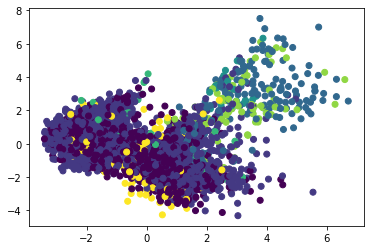

In [117]:
X = data
y = y_train

#from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=1).fit(X)
X = pca.transform(X)

plt.subplot(111)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

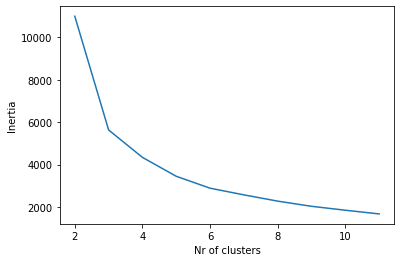

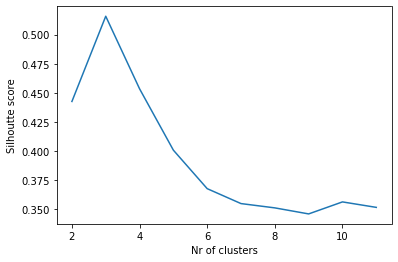

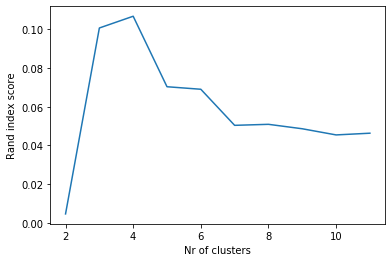

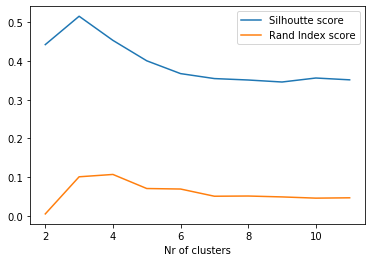

In [118]:
n_of_cluster = []
inertia_values = []
silhouette_values = []
rand_index_values = []

for i in range(2, 12):
    kmeans_model = cluster.KMeans(n_clusters=i, random_state=1).fit(X)
    y_pred = kmeans_model.labels_
    n_of_cluster.append(i) 
    inertia_values.append(kmeans_model.inertia_)
    silhouette_values.append(silhouette_score(X, y_pred))
    rand_index_values.append(adjusted_rand_score(y, y_pred))

# Inertia, diferença entre valores dentro do mesmo cluster, quão coerentes os clusters são internamente, o objetivo é minimizar este valor
plt.plot(n_of_cluster, inertia_values)
plt.xlabel("Nr of clusters")
plt.ylabel("Inertia")
plt.show()

# Silhouette, quão bem classificado está um sample no seu cluster, quanto mais alto for o valor melhor definido está o cluster
plt.plot(n_of_cluster, silhouette_values)
plt.xlabel("Nr of clusters")
plt.ylabel("Silhoutte score")
plt.show()

# Ajusted Rand Indexes, é a similariedade entre dois clusters, usamos para comparar o predicted com o verdadeiro
# requer saber as classes verdadeiras, 
# o valor 1.0 que é o mais alto é o perfeito significa classificação de labels perfeita
# distribuição uniforme (random) de labels tem um valor de 0.0
plt.plot(n_of_cluster, rand_index_values)
plt.xlabel("Nr of clusters")
plt.ylabel("Rand index score")
plt.show()

plt.plot(n_of_cluster, silhouette_values, label="Silhoutte score")
plt.plot(n_of_cluster, rand_index_values, label="Rand Index score")
plt.legend(loc='upper right')
plt.xlabel("Nr of clusters")
plt.show()

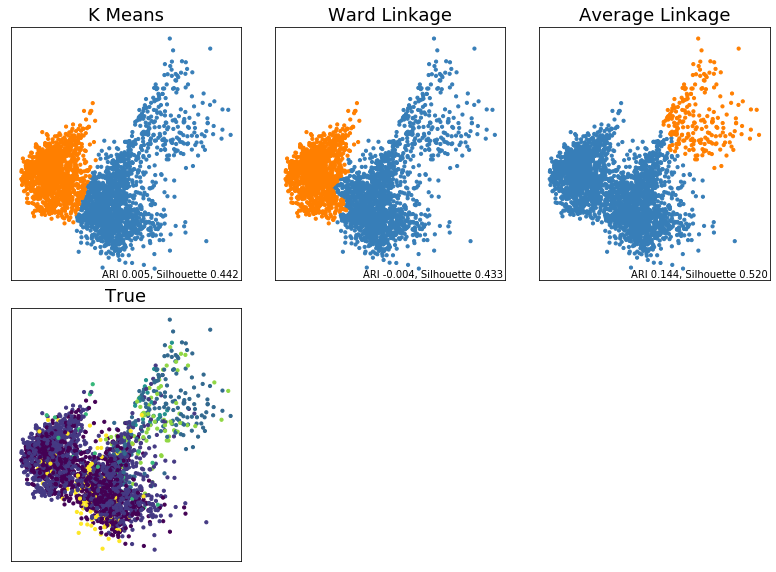

In [119]:
algorithms = {}
n_clusters = 2
    
# 1b Parameterize clustering algorithms
algorithms['K Means'] = cluster.KMeans(n_clusters=n_clusters, random_state=1)
algorithms['Ward Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
algorithms['Average Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='average')

# 3 Run clustering algorithm and store predictions
predictions = {}
efficiency = {}
for idx, name in enumerate(algorithms):
    clustering = algorithms[name]
    t0 = time.time()
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        clustering.fit(X)
    efficiency[name]= time.time()-t0
    if hasattr(clustering, 'labels_'): predictions[name] = clustering.labels_.astype(np.int)
    else: predictions[name] = clustering.predict(X)

plt.figure(figsize=(11, 8))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
color_array = ['#377eb8','#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00']
plot_num = 1

for idx, name in enumerate(predictions):
    y_predi = predictions[name]
    plt.subplot(2, 3, plot_num)
    plt.tight_layout()
    plt.title(name, size=18)
    plt.xticks([])
    plt.yticks([])
    colors = np.array(list(islice(cycle(color_array),int(max(y_predi) + 1))))
    colors = np.append(colors, ["#000000"]) #black color for outliers (if any)
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_predi])
    silh = str('%.3f'%(silhouette_score(X, y_predi)))
    ari = str('%.3f'%(adjusted_rand_score(y, y_predi)))
    plt.text(.99, .01, 'ARI '+ari+', Silhouette '+silh, transform=plt.gca().transAxes,size=10,horizontalalignment='right')
    plot_num += 1
    
plt.subplot(2, 3, plot_num)
plt.title("True", size=18)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], s=10, c=y)

plt.show()

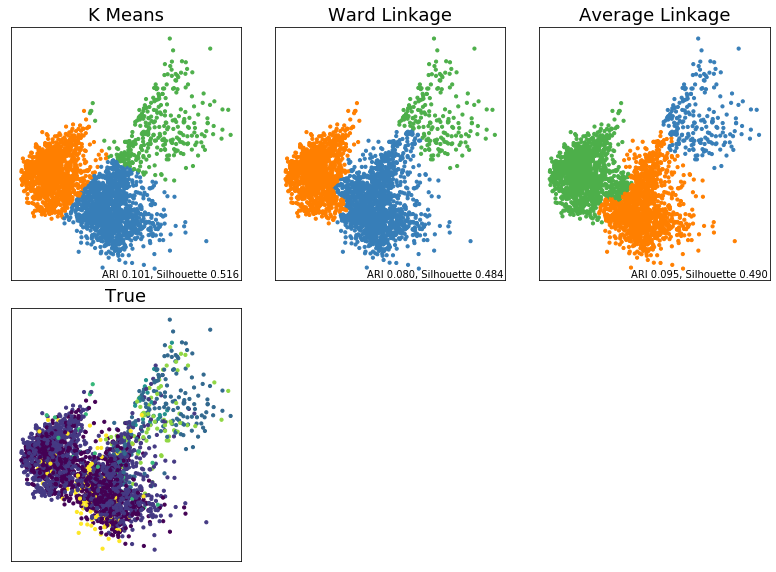

In [120]:
algorithms = {}
n_clusters = 3
    
# 1b Parameterize clustering algorithms
algorithms['K Means'] = cluster.KMeans(n_clusters=n_clusters, random_state=1)
algorithms['Ward Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
algorithms['Average Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='average')

# 3 Run clustering algorithm and store predictions
predictions = {}
efficiency = {}
for idx, name in enumerate(algorithms):
    clustering = algorithms[name]
    t0 = time.time()
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        clustering.fit(X)
    efficiency[name]= time.time()-t0
    if hasattr(clustering, 'labels_'): predictions[name] = clustering.labels_.astype(np.int)
    else: predictions[name] = clustering.predict(X)


plt.figure(figsize=(11, 8))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
color_array = ['#377eb8','#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00']
plot_num = 1

for idx, name in enumerate(predictions):
    y_predi = predictions[name]
    plt.subplot(2, 3, plot_num)
    plt.tight_layout()
    plt.title(name, size=18)
    plt.xticks([])
    plt.yticks([])
    colors = np.array(list(islice(cycle(color_array),int(max(y_predi) + 1))))
    colors = np.append(colors, ["#000000"]) #black color for outliers (if any)
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_predi])
    silh = str('%.3f'%(silhouette_score(X, y_predi)))
    ari = str('%.3f'%(adjusted_rand_score(y, y_predi)))
    plt.text(.99, .01, 'ARI '+ari+', Silhouette '+silh, transform=plt.gca().transAxes,size=10,horizontalalignment='right')
    plot_num += 1
    
plt.subplot(2, 3, plot_num)
plt.title("True", size=18)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], s=10, c=y)

plt.show()

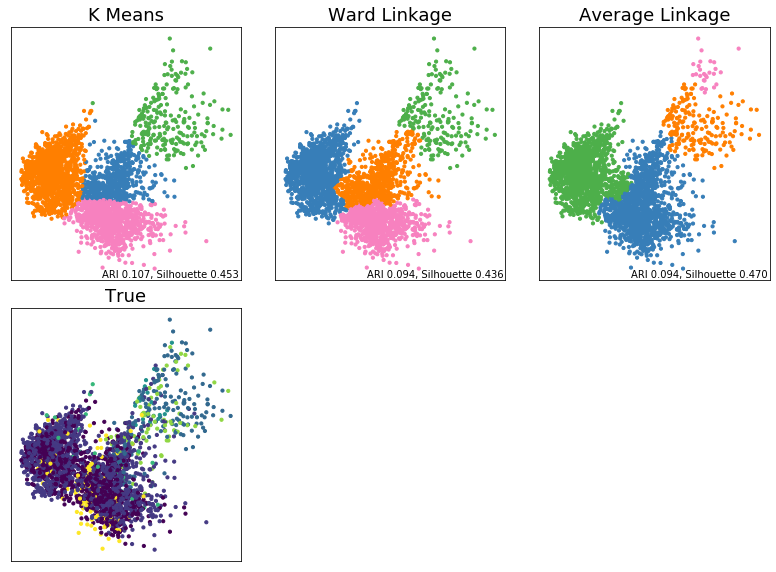

In [121]:
algorithms = {}
n_clusters = 4
    
# 1b Parameterize clustering algorithms
algorithms['K Means'] = cluster.KMeans(n_clusters=n_clusters, random_state=1)
algorithms['Ward Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
algorithms['Average Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='average')

# 3 Run clustering algorithm and store predictions
predictions = {}
efficiency = {}
for idx, name in enumerate(algorithms):
    clustering = algorithms[name]
    t0 = time.time()
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        clustering.fit(X)
    efficiency[name]= time.time()-t0
    if hasattr(clustering, 'labels_'): predictions[name] = clustering.labels_.astype(np.int)
    else: predictions[name] = clustering.predict(X)


plt.figure(figsize=(11, 8))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
color_array = ['#377eb8','#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00']
plot_num = 1

for idx, name in enumerate(predictions):
    y_predi = predictions[name]
    plt.subplot(2, 3, plot_num)
    plt.tight_layout()
    plt.title(name, size=18)
    plt.xticks([])
    plt.yticks([])
    colors = np.array(list(islice(cycle(color_array),int(max(y_predi) + 1))))
    colors = np.append(colors, ["#000000"]) #black color for outliers (if any)
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_predi])
    silh = str('%.3f'%(silhouette_score(X, y_predi)))
    ari = str('%.3f'%(adjusted_rand_score(y, y_predi)))
    plt.text(.99, .01, 'ARI '+ari+', Silhouette '+silh, transform=plt.gca().transAxes,size=10,horizontalalignment='right')
    plot_num += 1
    
plt.subplot(2, 3, plot_num)
plt.title("True", size=18)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], s=10, c=y)

plt.show()

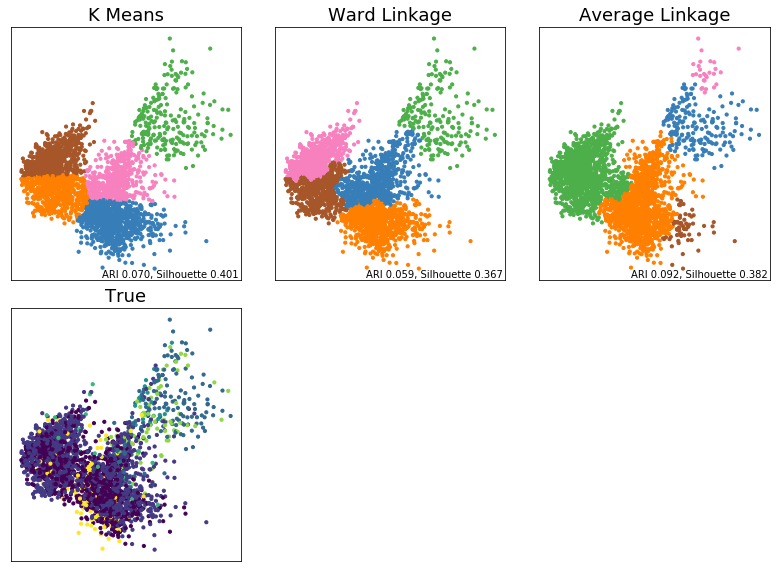

In [122]:
algorithms = {}
n_clusters = 5
    
# 1b Parameterize clustering algorithms
algorithms['K Means'] = cluster.KMeans(n_clusters=n_clusters, random_state=1)
algorithms['Ward Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
algorithms['Average Linkage'] = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='average')

# 3 Run clustering algorithm and store predictions
predictions = {}
efficiency = {}
for idx, name in enumerate(algorithms):
    clustering = algorithms[name]
    t0 = time.time()
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        clustering.fit(X)
    efficiency[name]= time.time()-t0
    if hasattr(clustering, 'labels_'): predictions[name] = clustering.labels_.astype(np.int)
    else: predictions[name] = clustering.predict(X)


plt.figure(figsize=(11, 8))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
color_array = ['#377eb8','#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00']
plot_num = 1

for idx, name in enumerate(predictions):
    y_predi = predictions[name]
    plt.subplot(2, 3, plot_num)
    plt.tight_layout()
    plt.title(name, size=18)
    plt.xticks([])
    plt.yticks([])
    colors = np.array(list(islice(cycle(color_array),int(max(y_predi) + 1))))
    colors = np.append(colors, ["#000000"]) #black color for outliers (if any)
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_predi])
    silh = str('%.3f'%(silhouette_score(X, y_predi)))
    ari = str('%.3f'%(adjusted_rand_score(y, y_predi)))
    plt.text(.99, .01, 'ARI '+ari+', Silhouette '+silh, transform=plt.gca().transAxes,size=10,horizontalalignment='right')
    plot_num += 1
    
plt.subplot(2, 3, plot_num)
plt.title("True", size=18)
plt.xticks([])
plt.yticks([])
plt.scatter(X[:, 0], X[:, 1], s=10, c=y)

plt.show()

# Best results for CovType dataset

|            | K Means - 4 clusters | Ward - 4 clusters | Average Linkage - 2 clusters |
|------------|----------------------|-------------------|------------------------------|
| Silhouette | 0,453                | 0,436             | 0,520                        |
| ARI        | 0,107                | 0,094             | 0,144                        |

The best is Average Linkage with 2 clusters